# 01 — GBM Simulation
In this notebook, we simulate **Geometric Brownian Motion (GBM)** price paths and verify key theoretical properties:

- Log-returns over a small time step are approximately normal
- The mean and variance of log-returns match theory
- Terminal prices are approximately lognormal

We will use the exact discretization of GBM:

$$
S_{t+\Delta t}
= S_t \exp\!\left(
\left(\mu - \frac{1}{2}\sigma^2\right)\Delta t
+ \sigma \sqrt{\Delta t}\, Z
\right),
\quad Z \sim \mathcal{N}(0,1).
$$

In [13]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

In [14]:
def simulate_gbm_paths(
    s0: float,
    mu: float,
    sigma: float,
    T: float,
    steps: int,
    n_paths: int,
    seed: int = 42
) -> tuple[np.ndarray, np.ndarray]:
    """
    Simulate GBM price paths using the exact discretization.

    Parameters
    ----------
    s0 : float
        Initial price S(0).
    mu : float
        Drift (annualized).
    sigma : float
        Volatility (annualized).
    T : float
        Time horizon in years.
    steps : int
        Number of time steps.
    n_paths : int
        Number of simulated paths.
    seed : int
        Random seed for reproducibility.

    Returns
    -------
    t : np.ndarray
        Time grid of shape (steps+1,).
    S : np.ndarray
        Simulated prices of shape (n_paths, steps+1).
    """
    if s0 <= 0:
        raise ValueError("s0 must be > 0.")
    if sigma < 0:
        raise ValueError("sigma must be >= 0.")
    if T <= 0:
        raise ValueError("T must be > 0.")
    if steps <= 0 or n_paths <= 0:
        raise ValueError("steps and n_paths must be positive integers.")

    rng = np.random.default_rng(seed)
    dt = T / steps
    t = np.linspace(0.0, T, steps + 1)

    # Z: (n_paths, steps)
    Z = rng.standard_normal(size=(n_paths, steps))

    # Log-increment
    drift = (mu - 0.5 * sigma**2) * dt
    diffusion = sigma * np.sqrt(dt) * Z
    log_increments = drift + diffusion

    # Build log prices
    logS = np.empty((n_paths, steps + 1), dtype=float)
    logS[:, 0] = np.log(s0)
    logS[:, 1:] = logS[:, [0]] + np.cumsum(log_increments, axis=1)

    S = np.exp(logS)
    return t, S

In [15]:
# Baseline parameters (annualized)
s0 = 100.0
mu = 0.08
sigma = 0.20
T = 1.0          # 1 year
steps = 252      # daily steps
n_paths = 2000

t, S = simulate_gbm_paths(s0, mu, sigma, T, steps, n_paths, seed=7)

S.shape

(2000, 253)

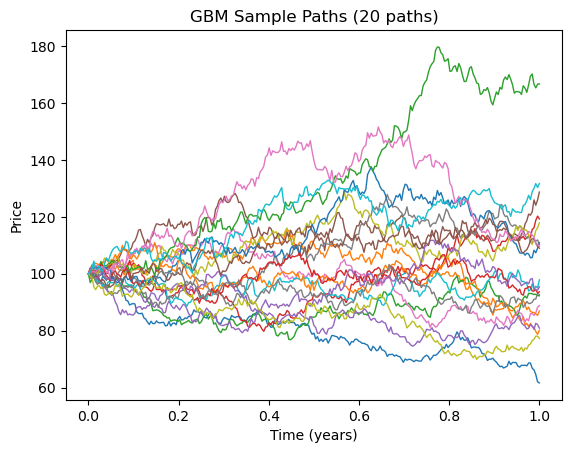

In [16]:
# Plot a few sample paths
plt.figure()
for i in range(20):
    plt.plot(t, S[i, :], linewidth=1)

plt.title("GBM Sample Paths (20 paths)")
plt.xlabel("Time (years)")
plt.ylabel("Price")
plt.show()

In [17]:
# Log returns: r_t = log(S_{t+1}/S_t)
log_returns = np.log(S[:, 1:] / S[:, :-1])   # shape: (n_paths, steps)
dt = T / steps

emp_mean = log_returns.mean()
emp_var = log_returns.var(ddof=0)

theo_mean = (mu - 0.5 * sigma**2) * dt
theo_var = (sigma**2) * dt

print("One-step log-return (all paths pooled)")
print(f"Empirical mean   : {emp_mean:.6f}")
print(f"Theoretical mean : {theo_mean:.6f}\n")
print(f"Empirical var    : {emp_var:.6f}")
print(f"Theoretical var  : {theo_var:.6f}")

One-step log-return (all paths pooled)
Empirical mean   : 0.000249
Theoretical mean : 0.000238

Empirical var    : 0.000158
Theoretical var  : 0.000159


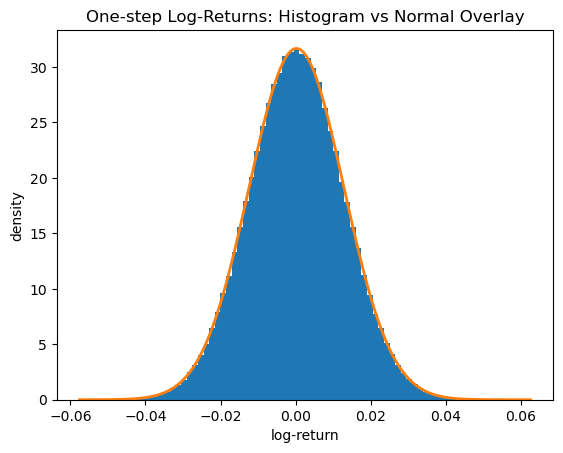

In [18]:
# Distribution check: histogram + normal overlay
x = log_returns.ravel()

plt.figure()
plt.hist(x, bins=80, density=True)

# Normal overlay with theoretical parameters
grid = np.linspace(x.min(), x.max(), 400)
pdf = stats.norm.pdf(grid, loc=theo_mean, scale=np.sqrt(theo_var))
plt.plot(grid, pdf, linewidth=2)

plt.title("One-step Log-Returns: Histogram vs Normal Overlay")
plt.xlabel("log-return")
plt.ylabel("density")
plt.show()

In [19]:
# Note: with huge sample sizes, normality tests often reject for tiny deviations.
# We'll compute a QQ-plot correlation instead, which is a simple diagnostic.

qq = stats.probplot(x, dist="norm", sparams=(theo_mean, np.sqrt(theo_var)))
osm = qq[0][0]  # theoretical quantiles
osr = qq[0][1]  # ordered responses

corr = np.corrcoef(osm, osr)[0, 1]
print(f"QQ-plot correlation (closer to 1 is more normal-looking): {corr:.6f}")

QQ-plot correlation (closer to 1 is more normal-looking): 0.999998


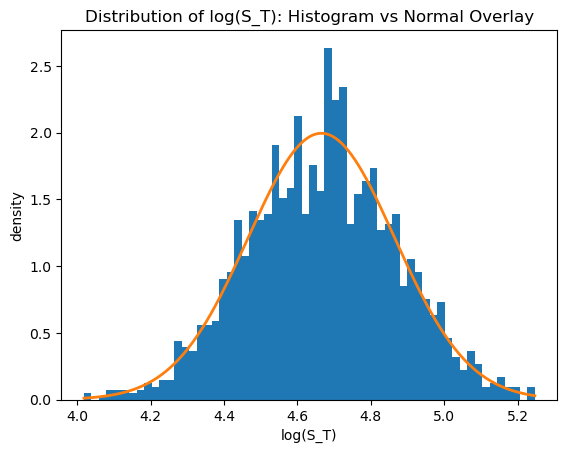

In [20]:
#Terminal distribution: check lognormality
ST = S[:, -1]
logST = np.log(ST)

# Theoretical distribution of log S_T:
# log(S_T) ~ Normal(log(S0) + (mu - 0.5*sigma^2)T, sigma^2 T)
mu_logT = np.log(s0) + (mu - 0.5 * sigma**2) * T
var_logT = sigma**2 * T

plt.figure()
plt.hist(logST, bins=60, density=True)

grid = np.linspace(logST.min(), logST.max(), 400)
pdf = stats.norm.pdf(grid, loc=mu_logT, scale=np.sqrt(var_logT))
plt.plot(grid, pdf, linewidth=2)

plt.title("Distribution of log(S_T): Histogram vs Normal Overlay")
plt.xlabel("log(S_T)")
plt.ylabel("density")
plt.show()

In [21]:
# Monte Carlo estimate of E[S_T] vs theorytical value
emp_ES_T = ST.mean()
theo_ES_T = s0 * np.exp(mu * T)

print(f"E[S_T] empirical  : {emp_ES_T:.4f}")
print(f"E[S_T] theoretical: {theo_ES_T:.4f}")
print(f"Relative error    : {(emp_ES_T - theo_ES_T)/theo_ES_T:.4%}")

E[S_T] empirical  : 108.6713
E[S_T] theoretical: 108.3287
Relative error    : 0.3163%
